# Zingerman's Findings 3.2 & 3.3

In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [86]:
sales_13_17 = pd.read_csv("13_17sales.txt")
sales_18_20 = pd.read_csv("18_20sales.txt")
sales_21_23 = pd.read_csv("21_23sales.txt")

In [87]:
sales_13_23 = pd.concat([sales_13_17, sales_18_20, sales_21_23])

In [88]:
sales_13_23.columns

Index(['OrderID', 'OrderTotalPrice', 'Order Discount Amount', 'OrderStatus',
       'BoxID', 'BoxStatus', 'ShippingCharge', 'OrderLineItemID', 'CreateDate',
       'SourceCode', 'PromoCode', 'BuyerCustomerID', 'SenderAddressId',
       'FirstName', 'LastName', 'Address1', 'Address2', 'CompanyName', 'City',
       'StateText', 'PostalCode', 'SenderEmail', 'RecipientFirstName',
       'RecipientLastName', 'RecipientAddress1', 'RecipientAddress2',
       'RecipientCompanyName', 'RecipientCity', 'RecipientStateText',
       'RecipientPostalCode', 'RecipientEmail', 'StockID', 'stockcode',
       'StockName', 'UnitPrice', 'Quantity', 'DiscountPercentage',
       'Discount Dollars', 'ClubStockCode', 'ClubStockName',
       'SummerShippingCharge', 'ShippingMethodName', 'ShipMethodDIT',
       'PP Networking', 'Zone', 'UPSCharge', 'Included Shipping Charges',
       'ScheduledShipDate', 'StockFamilyCode'],
      dtype='object')

In [89]:
sales_13_23['CreateDate'] = pd.to_datetime(sales_13_23['CreateDate']) 
# Extract month, day, year, week and day of the year from the order's created date
sales_13_23['Month'] = sales_13_23['CreateDate'].dt.month
sales_13_23['Day'] = sales_13_23['CreateDate'].dt.day
sales_13_23['Year'] = sales_13_23['CreateDate'].dt.year
sales_13_23['Week'] = sales_13_23['CreateDate'].dt.isocalendar().week
sales_13_23['DayOfYear'] = sales_13_23['CreateDate'].dt.dayofyear

In [90]:
sales_13_23.shape

(5423807, 54)

## DEFINING THE SEASONAL PEAK

In [91]:
nov_dec_data = sales_13_23[sales_13_23['Month'].isin([11,12])]
orders_per_week_nov_dec_year = nov_dec_data.groupby(['Year', 'Week'])['OrderID']\
                              .nunique().reset_index(name='OrdersPerWeekPerYear')
orders_per_week_nov_dec_year['pct_change'] = orders_per_week_nov_dec_year.groupby('Year')\
                                            ['OrdersPerWeekPerYear'].pct_change() * 100
orders_per_week_nov_dec_year['peak'] = (orders_per_week_nov_dec_year['pct_change'] > 20).astype(int)
orders_per_week_nov_dec_year

,Year,Week,OrdersPerWeekPerYear,pct_change,peak
0,2013,1,726,NaN,0
1,2013,44,629,-13.360882,0
2,2013,45,2085,231.478537,1
3,2013,46,3013,44.508393,1
4,2013,47,4085,35.579157,1
...,...,...,...,...,...
100,2023,48,10563,100.626781,1
101,2023,49,20977,98.589416,1
102,2023,50,29798,42.050818,1
103,2023,51,15915,-46.590375,0


In [92]:
sales_13_23 = pd.merge(sales_13_23, orders_per_week_nov_dec_year[['Year', 'Week', 'peak']], how='outer', on=['Year', 'Week'])
sales_13_23['peak'].fillna(0, inplace=True)

In [93]:
sales_13_23['peak'].value_counts(normalize=True)

peak
0.0    0.678046
1.0    0.321954
Name: proportion, dtype: float64

## SEASONAL PRODUCT PURCHASING

As discussed in class, it would be good to pair a more "advanced" clustering based approach with some simpler metrics that get at the intuition of on/off season, e.g., a per-product base rate of % purchases in the off season. It would also be good to check whether the product-based conceptualization of "lifestyle" actually relates to different customer behavior, e.g., do people who purchase canned fish once return to purchase canned fish again, etc.

In [94]:
seasonality_product_count = sales_13_23.groupby(['StockName', 'peak']).size().reset_index(name='SeasonalityCount')
total_product_counts = sales_13_23.groupby('StockName')['peak'].size().reset_index(name='totalCount')

In [95]:
total_product_counts

,StockName,totalCount
0,#4 Coffee Filter,32
1,'Ohi'a Lehua Honey,304
2,'Old' Pickles in a Jar,725
3,'Thank You' Gift Box,331
4,(Better Than) San Francisco Style Sourdough,14967
...,...,...
4302,one10 Marketing Gift Note,57
4303,packaging tape,9
4304,sal marinho traditional salt,3
4305,tissue paper - printed zing,1


In [96]:
season_total_counts = pd.merge(seasonality_product_count, total_product_counts, on=['StockName'])
season_total_counts['PercentageSales'] = season_total_counts['SeasonalityCount']/season_total_counts['totalCount'] * 100

In [97]:
season_total_counts

,StockName,peak,SeasonalityCount,totalCount,PercentageSales
0,#4 Coffee Filter,0.0,31,32,96.875000
1,#4 Coffee Filter,1.0,1,32,3.125000
2,'Ohi'a Lehua Honey,0.0,253,304,83.223684
3,'Ohi'a Lehua Honey,1.0,51,304,16.776316
4,'Old' Pickles in a Jar,0.0,608,725,83.862069
...,...,...,...,...,...
7386,packaging tape,1.0,1,9,11.111111
7387,sal marinho traditional salt,0.0,3,3,100.000000
7388,tissue paper - printed zing,1.0,1,1,100.000000
7389,urfa pepper,0.0,23,29,79.310345


In [98]:
season_total_counts.pivot(index='StockName', columns='peak', values='PercentageSales').isna().sum()

peak
0.0     141
1.0    1082
dtype: int64

In [99]:
df_pivot = season_total_counts.pivot(index='StockName', columns='peak', values='PercentageSales')
df_pivot = pd.concat([df_pivot, sales_13_23['StockName'].value_counts(), sales_13_23.groupby('StockName').agg({'UnitPrice':'mean'})], axis=1)

# Rename the columns for clarity (0 = off-season, 1 = on-season)
df_pivot.columns = ['off_season', 'on_season', 'totalCount', 'unitPrice']

# Filter products where off-season sales are greater than on-season sales
off_season_popular_items = df_pivot[df_pivot['on_season'] < df_pivot['off_season']]
off_season_popular_items.sort_values(by="totalCount", ascending=False)

,off_season,on_season,totalCount,unitPrice
StockName,,,,
The Weekender Gift Box,59.037315,40.962685,107034,90.938512
Printed Gift Note,52.140800,47.859200,73267,0.967164
Cinnful Cinnamon Rolls in Cartoon Cardboard Box,57.783399,42.216601,58901,40.915460
Bacon Club Installment 1,56.015757,43.984243,54324,34.131895
Bacon Club Installment 2,55.984734,44.015266,54238,33.891828
...,...,...,...,...
Agrimontana Fruit Jellies,66.666667,33.333333,3,12.000000
Zingerman's Gift Box With No Label,66.666667,33.333333,3,125.000000
Bacon All Year Club - Literature 1,66.666667,33.333333,3,0.000000


In [100]:
off_season_popular_items.sort_values(by="off_season", ascending=False).head(25)

,off_season,on_season,totalCount,unitPrice
StockName,,,,
Ortiz Bonito Loin Tinned Tuna - case of 12,99.970318,0.029682,3369,68.023152
Spring Sale 4 Cured Meats & Cheeses plus Bread Cus,99.944736,0.055264,3619,70.566452
Il Mongetto Original Tomato Sauce - case of 12 jar,99.899900,0.100100,999,71.937938
Summer Fling Coffee Cake in our Cartoon Gift Box,99.883586,0.116414,859,51.181607
Karamel Krunch Handmade Halloween Candy,99.850969,0.149031,671,28.801803
Kifli Almond Cookies,99.820789,0.179211,558,34.879032
Virginia Diner Peanuts - case of 12,99.812383,0.187617,533,45.000000
Gentile Napoletani Pasta - case of 12,99.765258,0.234742,426,62.000000
Irish Brown Soda Bread,99.740484,0.259516,1156,14.104671


In [101]:
off_season_popular_items.unitPrice.mean()

43.74968472625461

In [102]:
off_season_popular_items.unitPrice.median()

22.85250176180409

In [103]:
on_season_popular_items = df_pivot[df_pivot['on_season'] > df_pivot['off_season']]
on_season_popular_items.sort_values(by="totalCount", ascending=False)

,off_season,on_season,totalCount,unitPrice
StockName,,,,
Professional Presents Logo Gift Note,46.313846,53.686154,36298,1.941567
Fresser Sour Cream Coffee Cake in our Cartoon Gift,47.702603,52.297397,32428,56.683548
Clementines in Chocolate,44.476114,55.523886,24910,28.420140
Large 'Fresser' Sour Cream Coffee Cake in Cartoon,44.409507,55.590493,24488,62.791207
Professional Presents Printed Gift Note,36.975309,63.024691,19440,0.983796
...,...,...,...,...
Effie's Malted Cocoa Cakes,25.000000,75.000000,4,9.000000
Styro Box (Fondant Cakes),33.333333,66.666667,3,0.000000
La Quercia Acorn Edition Prosciutto,33.333333,66.666667,3,1000.000000


In [104]:
on_season_popular_items.sort_values(by="on_season", ascending=False).head(25)

,off_season,on_season,totalCount,unitPrice
StockName,,,,
Atlas Bread Box,0.410275,99.589725,5606,46.537638
Beehive Gift Note,0.429185,99.570815,233,2.000000
Union Partners Gift Crate,0.546448,99.453552,183,125.000000
Muraglia Olive Oil - Collectors Edition,1.639344,98.360656,61,65.000000
Detroit Regional Partnership Thank You,1.639344,98.360656,122,0.000000
Reindeer Crunch Popcorn & Nut Snack Mix,1.960784,98.039216,204,30.000000
Union Partners Internal Gift Box,2.040816,97.959184,49,253.050000
Iberico Jowl Bacon,4.444444,95.555556,45,24.288889
Chocolate Christmas Ornament,4.545455,95.454545,88,20.000000


/var/folders/c5/pfcqzhrn7w15jg9w7c0n08b40000gn/T/ipykernel_15504/2459315901.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  off_season_popular_items['type'] = 'off'
/var/folders/c5/pfcqzhrn7w15jg9w7c0n08b40000gn/T/ipykernel_15504/2459315901.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  on_season_popular_items['type'] = 'on'


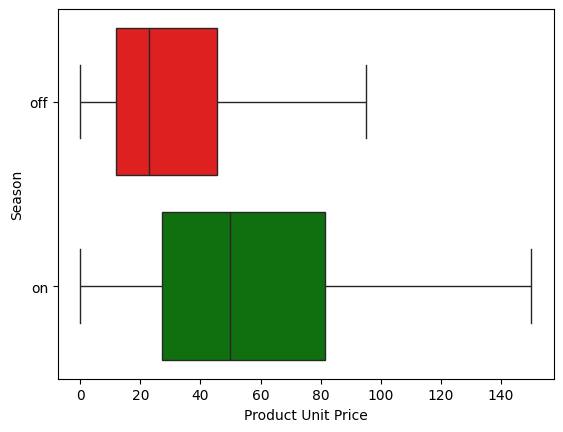

In [105]:
off_season_popular_items['type'] = 'off'
on_season_popular_items['type'] = 'on'
on_off_products = pd.concat([off_season_popular_items, on_season_popular_items])
sns.boxplot(x='unitPrice', y='type', hue='type', data=on_off_products, showfliers=False, palette={'on': 'green', 'off': 'red'})
plt.ylabel('Season')
plt.xlabel('Product Unit Price')
_ = plt.title('')

### HYPOTHESIS TEST
### Do items purchased more frequently during the peak season cost more than items purchased more frequently during the off season?

In [106]:
import numpy as np
from scipy import stats

mean_on = on_season_popular_items.unitPrice.mean()
mean_off = off_season_popular_items.unitPrice.mean()
std_on = on_season_popular_items.unitPrice.std() 
std_off = off_season_popular_items.unitPrice.std()  
n_on = len(on_season_popular_items)
n_off = len(off_season_popular_items)

# two-sample t-test
t_stat, p_value = stats.ttest_ind(on_season_popular_items.unitPrice, off_season_popular_items.unitPrice, alternative='greater')

print(f"On-season mean: {mean_on:.2f}, Off-season mean: {mean_off:.2f}")
print(f"On-season std dev: {std_on:.2f}, Off-season std dev: {std_off:.2f}")
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.5f}")

# reject or fail to reject the null hypothesis based on the p-value
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: On-season items cost more on average than off-season items.")
else:
    print("Fail to reject the null hypothesis: No significant difference in cost.")

On-season mean: 71.59, Off-season mean: 43.75
On-season std dev: 91.74, Off-season std dev: 60.59
t-statistic: 8.320
p-value: 0.00000
Reject the null hypothesis: On-season items cost more on average than off-season items.


### IN ON AND OFF SEASON LIKELIHOOD

In [107]:
from collections import Counter
import matplotlib.pyplot as plt

patterns = ['gift box', 'gift', 'box', 'crate', 'case', 'collection', 'club', \
            'pack', 'sampler', 'customizable', 'deluxe', 'fancy', 'holiday', 'christmas', \
                'thanksgiving', 'easter', 'valentine', 'halloween', 'new year', 'seasonal']

# function to extract patterns from product names
def extract_patterns(product_names, patterns):
    found_patterns = []
    for name in product_names:
        name = name.lower()  # Convert to lowercase for case-insensitive matching
        for pattern in patterns:
            if pattern.lower() in name:
                found_patterns.append(pattern.lower())
    return found_patterns

# extract patterns for both dataframes
off_patterns = extract_patterns(sales_13_23[sales_13_23['peak'] == 0].StockName, patterns)
on_patterns = extract_patterns(sales_13_23[sales_13_23['peak'] == 1].StockName, patterns)

# count the frequency of each pattern in both dataframes
off_pattern_counts = Counter(off_patterns)
on_pattern_counts = Counter(on_patterns)
# normalize by total items in both dataframes
norm_off_pattern_counts = {key: value / len(off_season_popular_items) for key, value in off_pattern_counts.items()}
norm_on_pattern_counts = {key: value / len(on_season_popular_items) for key, value in on_pattern_counts.items()}

# calculate total number of purchases for both on-season and off-season
total_on_season = sum(on_pattern_counts.values())  # Total purchases in the on-season group
total_off_season = sum(off_pattern_counts.values())  # Total purchases in the off-season group

# normalize the pattern counts to get the frequency of each pattern
on_freq = {key: count / total_on_season for key, count in on_pattern_counts.items()}
off_freq = {key: count / total_off_season for key, count in off_pattern_counts.items()}

# calculate the likelihood ratio (on-season / off-season)
likelihood_ratios = {}
all_patterns = set(on_freq.keys()).union(set(off_freq.keys()))  # All unique patterns from both groups

for pattern in all_patterns:
    # if the pattern is not present in one of the groups, assume a frequency of 0
    on_rate = on_freq.get(pattern, 0)
    off_rate = off_freq.get(pattern, 0)
    
    # calculate likelihood ratio, protecting against division by zero
    if off_rate > 0:
        likelihood_ratios[pattern] = on_rate / off_rate
    else:
        likelihood_ratios[pattern] = float('inf')  # Assign infinity if the off-season rate is zero

# convert the results to a dataframe
likelihood_df_season = pd.DataFrame(list(likelihood_ratios.items()), columns=['Pattern', 'Likelihood Ratio'])

# sort the DataFrame by Likelihood Ratio in descending order to see patterns more likely purchased in the on-season
likelihood_df_season = likelihood_df_season.sort_values(by='Likelihood Ratio', ascending=False)
likelihood_df_season

,Pattern,Likelihood Ratio
15,christmas,3.058490
1,fancy,2.699566
14,holiday,2.437367
11,thanksgiving,1.771724
0,crate,1.385046
5,club,1.036848
4,box,1.020200
17,gift,1.016394
10,gift box,0.975633
18,deluxe,0.957586


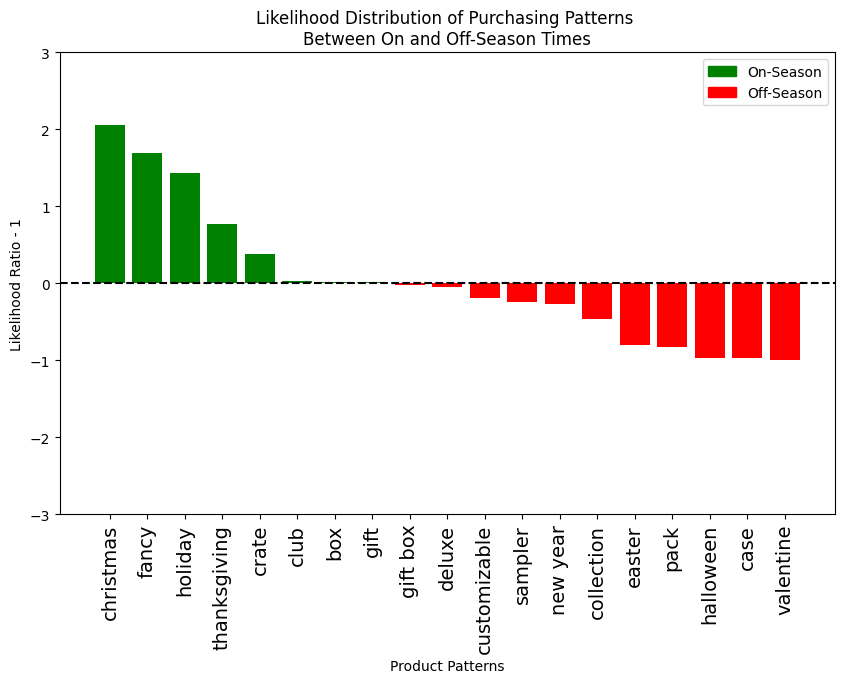

In [108]:
df = likelihood_df_season[likelihood_df_season['Likelihood Ratio'] > 0]

# Transform likelihood ratios to shift y = 1 to the baseline
df['Shifted LR'] = df['Likelihood Ratio'] - 1  # Subtract 1 from each likelihood ratio

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10,6))

# Plot the bars, color them based on whether they are above or below 1
bars = ax.bar(df['Pattern'], df['Shifted LR'], color=['g' if x > 0 else 'r' for x in df['Shifted LR']])

# Add a horizontal line at y = 0 (which now corresponds to LR = 1)
ax.axhline(y=0, color='black', linestyle='--', label='y = 1')

# Set the y-axis limits to make sure everything fits around y = 1
ax.set_ylim(-3, 3)  # Adjust based on your data range

# Add labels and title
ax.set_xlabel('Product Patterns')
ax.set_ylabel('Likelihood Ratio - 1')
plt.xticks(rotation=90, fontsize=14)
ax.set_title('Likelihood Distribution of Purchasing Patterns \nBetween On and Off-Season Times')

# Create custom legend for the bars
handles = [plt.Rectangle((0, 0), 1, 1, color='g'),  # Green for values > 1
           plt.Rectangle((0, 0), 1, 1, color='r')]  # Red for values < 1
labels = ['On-Season', 'Off-Season']

# Add custom legend to the plot
ax.legend(handles=handles, labels=labels)

# Show the plot
plt.show()

There is an apparent difference in the items and customer purchasing behaviors on and off-season.

In [109]:
likelihood_df_season[likelihood_df_season['Likelihood Ratio'] > 1]

,Pattern,Likelihood Ratio
15,christmas,3.058490
1,fancy,2.699566
14,holiday,2.437367
11,thanksgiving,1.771724
0,crate,1.385046
5,club,1.036848
4,box,1.020200
17,gift,1.016394


In [110]:
likelihood_df_season[likelihood_df_season['Likelihood Ratio'] < 1]

,Pattern,Likelihood Ratio
10,gift box,0.975633
18,deluxe,0.957586
2,customizable,0.811871
3,sampler,0.756904
16,new year,0.730964
9,collection,0.539457
13,easter,0.201631
6,pack,0.169552
7,halloween,0.036990
12,case,0.030477


It seems that gift boxes, collections, samplers, crates, luxury goods, and items related to holidays that fall around the "peak" season are more popular during Zingerman's on season while cases, packs, and customizable products are more popular during the company's "off season".

In [111]:
on_season_popular_items

,off_season,on_season,totalCount,unitPrice,type
StockName,,,,,
(Better than) Bubbe's Baked Goods Gift Box,42.605156,57.394844,737,120.930122,on
(Better than) Bubbe's Sweet Treats Gift Box,45.758929,54.241071,896,89.883929,on
100 Piece Custom Mini Pastry Sampler in a Cartoon,31.818182,68.181818,66,200.000000,on
150 Piece Custom Mini Pastry Sampler in a Wooden C,30.555556,69.444444,36,275.000000,on
20 Piece Custom Mini Pastry Sampler in a Cartoon B,49.909190,50.090810,2753,40.000000,on
...,...,...,...,...,...
Zingerman's Stollen,20.429741,79.570259,2932,39.713506,on
Zingerman's Sunday Afternoon Bakery Basket,46.518987,53.481013,632,125.071203,on
Zingerman's Triple Pie Party Gift Box,36.563877,63.436123,681,49.998546,on


In [112]:
sales_13_23['StockName']

0                               Fresser Stollen Gift Boxed
1             Zingerman's Custom Nosher Coffeecake Sampler
2          Cinnful Cinnamon Rolls in Cartoon Cardboard Box
3                                     Maitelates Alfajores
4                                     Maitelates Alfajores
                                ...                       
5423802                       Olive Oil Club Installment 2
5423803                       Olive Oil Club Installment 2
5423804                               1 Loaf Installment 4
5423805                               1 Loaf Installment 5
5423806                               1 Loaf Installment 6
Name: StockName, Length: 5423807, dtype: object

In [113]:
from collections import Counter
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def top_prod_words(df, top_n=10):
  flattened_words = [word.lower() for sublist in df for word in sublist if word.lower() not in stop_words]
  word_counts = Counter(flattened_words)
  word_counts_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])
  word_counts_df = word_counts_df.sort_values(by='Frequency', ascending=False)

  return word_counts_df.head(top_n), set(word_counts_df.head(top_n)['Word'])

In [114]:
on_season_products = sales_13_23[sales_13_23['peak'] == 1]['StockName'].str.split()
off_season_products = sales_13_23[sales_13_23['peak'] == 0]['StockName'].str.split()
on_df, set_on = top_prod_words(on_season_products, 20)
off_df, set_off = top_prod_words(off_season_products, 20)

In [115]:
# words in top 20 on season product list that are not in top off season list
print(set_on.difference(set_off))

# products in top 20 off season product list that are not in top on season list
print(set_off.difference(set_on))

{'wooden', 'sour', 'coffeecake', '2', 'note'}
{'customizable', 'olive', 'oil', '-', 'custom'}


In [116]:
on_pop_df, set_pop_on = top_prod_words(pd.Series(on_season_popular_items.index.str.split()), 20)
off_pop_df, set_pop_off = top_prod_words(pd.Series(off_season_popular_items.index.str.split()), 20)

In [117]:
# words in top 20 on season product list that are not in top off season list
print(set_pop_on.difference(set_pop_off))

# products in top 20 off season product list that are not in top on season list
print(set_pop_off.difference(set_pop_on))


# combination of two differences above without previously investigated word characters
print([word for word in set_pop_off.symmetric_difference(set_pop_on) if word not in patterns])

{'crate', 'cartoon', 'wooden', 'piece', 'coffeecake', 'gingerbread', 'fresser', 'holiday', 'christmas', 'nosher'}
{'3', '*', "zingerman's", 'sliced', 'bread', 'olive', 'oil', 'bacon', 'sauce', '1'}
['cartoon', '3', 'piece', 'sliced', 'coffeecake', 'olive', 'gingerbread', 'oil', 'fresser', 'bacon', 'sauce', 'nosher', 'wooden', '*', "zingerman's", 'bread', '1']


In [118]:
new_patterns = list(set_pop_off.symmetric_difference(set_pop_on))


# extract patterns for both dataframes
off_patterns = extract_patterns(sales_13_23[sales_13_23['peak'] == 0].StockName, new_patterns)
on_patterns = extract_patterns(sales_13_23[sales_13_23['peak'] == 1].StockName, new_patterns)

# count the frequency of each pattern in both dataframes
off_pattern_counts = Counter(off_patterns)
on_pattern_counts = Counter(on_patterns)
# normalize by total items in both dataframes
norm_off_pattern_counts = {key: value / len(off_season_popular_items) for key, value in off_pattern_counts.items()}
norm_on_pattern_counts = {key: value / len(on_season_popular_items) for key, value in on_pattern_counts.items()}

# calculate total number of purchases for both on-season and off-season
total_on_season = sum(on_pattern_counts.values())  # Total purchases in the on-season group
total_off_season = sum(off_pattern_counts.values())  # Total purchases in the off-season group

# normalize the pattern counts to get the frequency of each pattern
on_freq = {key: count / total_on_season for key, count in on_pattern_counts.items()}
off_freq = {key: count / total_off_season for key, count in off_pattern_counts.items()}

# calculate the likelihood ratio (on-season / off-season)
likelihood_ratios = {}
all_patterns = set(on_freq.keys()).union(set(off_freq.keys()))  # All unique patterns from both groups

for pattern in all_patterns:
    # if the pattern is not present in one of the groups, assume a frequency of 0
    on_rate = on_freq.get(pattern, 0)
    off_rate = off_freq.get(pattern, 0)
    
    # calculate likelihood ratio, protecting against division by zero
    if off_rate > 0:
        likelihood_ratios[pattern] = on_rate / off_rate
    else:
        likelihood_ratios[pattern] = float('inf')  # Assign infinity if the off-season rate is zero

# convert the results to a dataframe
likelihood_df_season = pd.DataFrame(list(likelihood_ratios.items()), columns=['Pattern', 'Likelihood Ratio'])

# sort the DataFrame by Likelihood Ratio in descending order to see patterns more likely purchased in the on-season
likelihood_df_season = likelihood_df_season.sort_values(by='Likelihood Ratio', ascending=False)
likelihood_df_season

,Pattern,Likelihood Ratio
15,christmas,3.585670
14,holiday,2.857486
3,gingerbread,2.588898
12,fresser,2.059900
17,wooden,1.850066
9,coffeecake,1.840699
0,crate,1.623780
4,nosher,1.552574
7,cartoon,1.470458
8,piece,1.249335


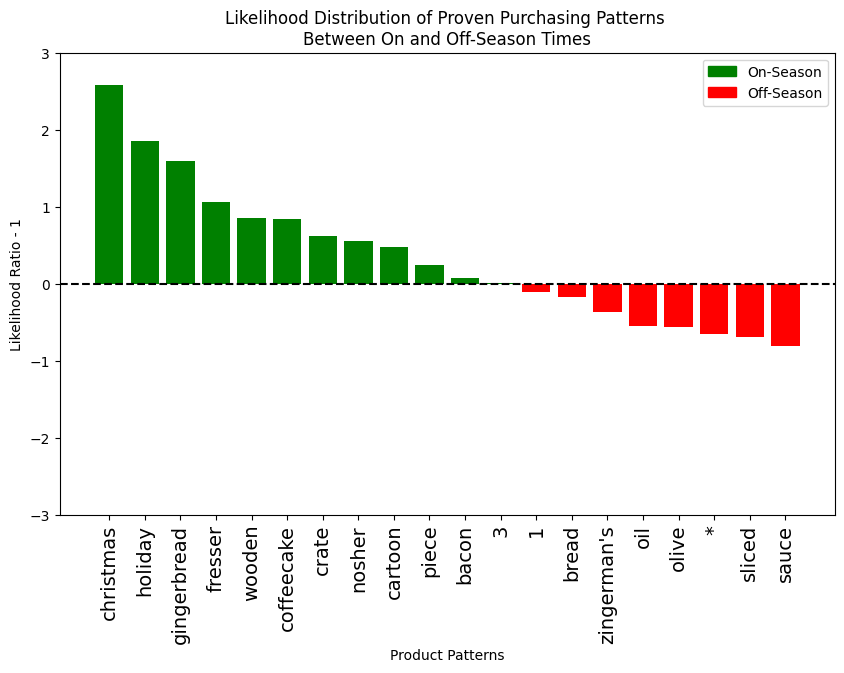

In [119]:
df = likelihood_df_season[likelihood_df_season['Likelihood Ratio'] > 0]

# Transform likelihood ratios to shift y = 1 to the baseline
df['Shifted LR'] = df['Likelihood Ratio'] - 1  # Subtract 1 from each likelihood ratio

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10,6))

# Plot the bars, color them based on whether they are above or below 1
bars = ax.bar(df['Pattern'], df['Shifted LR'], color=['g' if x > 0 else 'r' for x in df['Shifted LR']])

# Add a horizontal line at y = 0 (which now corresponds to LR = 1)
ax.axhline(y=0, color='black', linestyle='--', label='y = 1')

# Set the y-axis limits to make sure everything fits around y = 1
ax.set_ylim(-3, 3)  # Adjust based on your data range

# Add labels and title
ax.set_xlabel('Product Patterns')
ax.set_ylabel('Likelihood Ratio - 1')
plt.xticks(rotation=90, fontsize=14)
ax.set_title('Likelihood Distribution of Proven Purchasing Patterns \nBetween On and Off-Season Times')

# Create custom legend for the bars
handles = [plt.Rectangle((0, 0), 1, 1, color='g'),  # Green for values > 1
           plt.Rectangle((0, 0), 1, 1, color='r')]  # Red for values < 1
labels = ['On-Season', 'Off-Season']

# Add custom legend to the plot
ax.legend(handles=handles, labels=labels)

# Show the plot
plt.show()